In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras import Sequential
from keras.src.layers import LSTM, Dense

In [16]:
data_size = 500
df = pd.read_csv('..\..\Data\AAPL_stock_prices.csv', delimiter=',')
df = df.iloc[-data_size:, :]
dates = pd.to_datetime(df['Date'])
df.drop(columns=['Date'], inplace=True)
df.index = dates

target_column_index = df.columns.tolist().index('Close')
print(target_column_index)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)
print(scaled_data[-2:, :])
print(df.head())

3
[[0.90862378 0.90187908 0.90265006 0.91982487 0.92744333 0.36321875]
 [0.92889862 0.93556034 0.93848695 0.94417839 0.95163103 0.18464958]]
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-06-07  144.350006  149.000000  144.100006  148.710007  147.046371   
2022-06-08  148.580002  149.869995  147.460007  147.960007  146.304749   
2022-06-09  147.080002  147.949997  142.529999  142.639999  141.044250   
2022-06-10  140.279999  140.759995  137.059998  137.130005  135.595947   
2022-06-13  132.869995  135.199997  131.440002  131.880005  130.404633   

               Volume  
Date                   
2022-06-07   67808200  
2022-06-08   53950200  
2022-06-09   69473000  
2022-06-10   91437900  
2022-06-13  122207100  


In [17]:
# def create_dataset(data: np.ndarray, time_step: int=10):
#     feature_number = data.shape[1]
#     Y = []
#     X = np.full((len(range(time_step, len(data) - 1)), time_step, feature_number), np.nan, dtype=float)
#     print(X.shape)
#     for i in range(time_step, len(data) - 1):
#         window = data[i - time_step : i, 0]

#         X[i - time_step, :, 0] = window.flatten()

#         Y.append(data[i, 0])
        
#     return X, np.array(Y, dtype=float).reshape(-1, 1), feature_number, time_step

def create_dataset(data: np.ndarray, time_step: int=10):
    X, Y = [], []
    for i in range(len(data) - time_step):
        # Define the range of input sequences
        end_ix = i + time_step
        
        # Define the range of output sequences
        out_end_ix = end_ix + 1
        
        # Ensure that the dataset is within bounds
        if out_end_ix > len(data)-1:
            break
            
        # Extract input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix], data[out_end_ix]
        
        # Append the parts
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y), data.shape[1], time_step


X, Y, feature_number, time_step = create_dataset(data=scaled_data)

print(type(X), type(Y), feature_number, time_step, sep=' ')
print(X.shape, Y.shape)
print(f"X:\n{X[:1, :]=}\nY:\n{Y[:1]=}")

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 6 10
(489, 10, 6) (489, 6)
X:
X[:1, :]=array([[[0.2546869 , 0.29547674, 0.27365107, 0.32412107, 0.31318908,
         0.31098447],
        [0.31342868, 0.30758523, 0.31978591, 0.31385975, 0.30311146,
         0.21250109],
        [0.29259824, 0.28086292, 0.25209392, 0.24107267, 0.23162863,
         0.32281555],
        [0.19816687, 0.18079329, 0.17698749, 0.16568624, 0.15759379,
         0.4789115 ],
        [0.09526445, 0.10340989, 0.09982156, 0.093857  , 0.08705107,
         0.69757615],
        [0.09887519, 0.08517749, 0.10037069, 0.1058968 , 0.09887557,
         0.43162697],
        [0.1149839 , 0.13319415, 0.10970761, 0.14242708, 0.13475093,
         0.47958733],
        [0.08429384, 0.06430067, 0.06686798, 0.06895609, 0.06259651,
         0.59749236],
        [0.05638113, 0.07390404, 0.0774406 , 0.08947873, 0.08275134,
         0.78508124],
        [0.10290232, 0.12929716, 0.12563516, 0.14844709, 0.14066319,
         0.40473698]]])
Y

(489, 10, 6)
(489, 6)


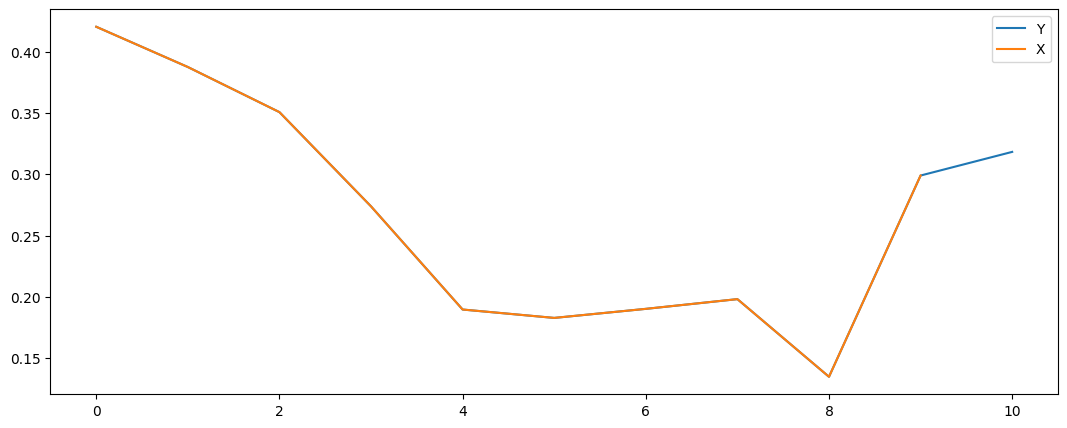

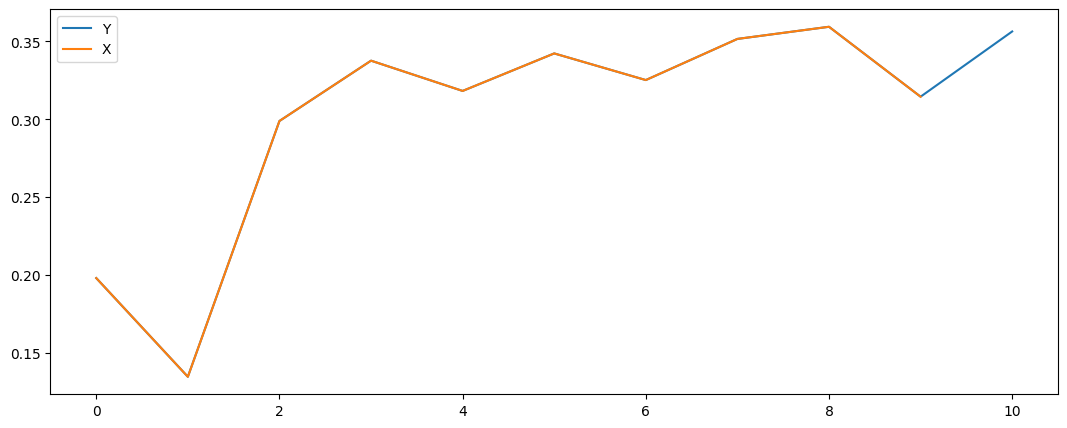

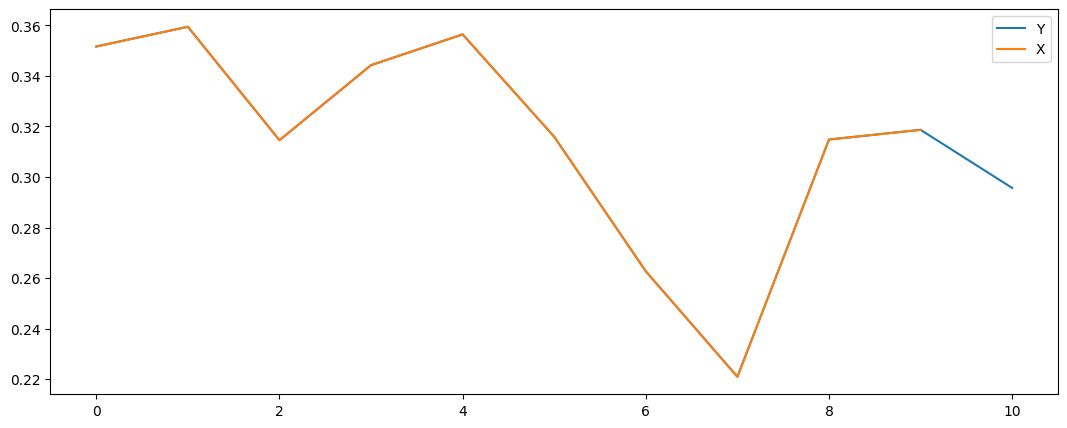

In [18]:
# Plot X and Y
print(X.shape)
print(Y.shape)
for i in range(100,121, 7):
    plot_X, plot_all = [], []
    for value in range(X.shape[1]):
      plot_X.append(X[i, value, target_column_index])
      plot_all.append(X[i, value, target_column_index])
    plot_all.append(Y[i, target_column_index])

    plt.figure(figsize=(13, 5))
    plt.plot(plot_all, label='Y')
    plt.plot(plot_X, label='X')
    plt.legend()
    plt.show()

In [19]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(342, 10, 6) (342, 6)
(147, 10, 6) (147, 6)


In [20]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], feature_number)))
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], feature_number)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\orhun\.conda\envs\stockprice\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=1, verbose=1)

Epoch 1/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0445 - val_loss: 0.0579
Epoch 2/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0251 - val_loss: 0.0579
Epoch 3/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0264 - val_loss: 0.0513
Epoch 4/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0263 - val_loss: 0.0538
Epoch 5/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0234 - val_loss: 0.0531
Epoch 6/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0230 - val_loss: 0.0502
Epoch 7/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0234 - val_loss: 0.0519
Epoch 8/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0240 - val_loss: 0.0501
Epoch 9/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0211 - val_loss: 0.0523
Epoch 10/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0244 - val_loss: 0.0522
Epoch 11/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0220 - val_loss: 0.0518
Epoch 12/50
342/342 ━━━━━━━━━━━━━━━━━━━━

dict_keys(['loss', 'val_loss'])


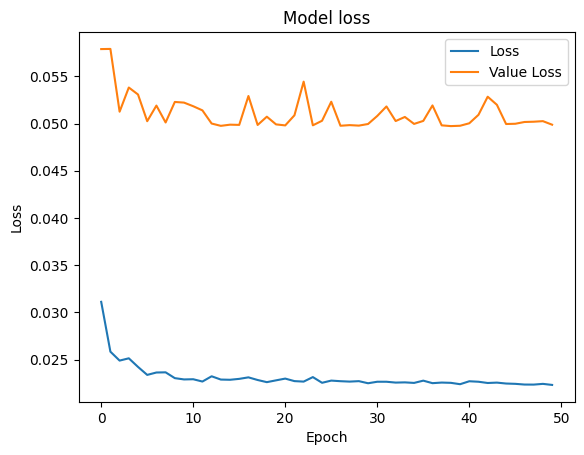

In [22]:
# Plot training & validation loss values
print(history.history.keys())
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Value Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [23]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [24]:
print(f"{train_predict.shape=}, {test_predict.shape=}, {Y_train.shape=}, {Y_test.shape=}")
# print(train_predict[:2, :])

train_predict.shape=(342, 1), test_predict.shape=(147, 1), Y_train.shape=(342, 6), Y_test.shape=(147, 6)


In [25]:
# Inverse transform the predictions
def update_data_to_inverse(predicted_data: np.ndarray, scaler: MinMaxScaler, target_column_index: int):
    new_dataset = np.zeros(shape=(len(predicted_data), feature_number))
    new_dataset[:,target_column_index] = predicted_data.flatten()
    return scaler.inverse_transform(new_dataset)[:, target_column_index].reshape(-1, 1)

In [26]:
train_predict = update_data_to_inverse(predicted_data=train_predict, scaler=scaler, target_column_index=target_column_index)
test_predict = update_data_to_inverse(predicted_data=test_predict, scaler=scaler, target_column_index=target_column_index)
Y_train = scaler.inverse_transform(Y_train)
Y_test = scaler.inverse_transform(Y_test)

print(f"{train_predict.shape=}, {test_predict.shape=}, {Y_train.shape=}, {Y_test.shape=}")
print(train_predict[:2, :])

train_predict.shape=(342, 1), test_predict.shape=(147, 1), Y_train.shape=(342, 6), Y_test.shape=(147, 6)
[[139.2795369 ]
 [139.78301695]]


In [27]:
# Calculate MSE
train_mse = mean_squared_error(Y_train[:, target_column_index].reshape(-1, 1), train_predict)
test_mse = mean_squared_error(Y_test[:, target_column_index].reshape(-1, 1), test_predict)

# Calculate R2 score
train_r2 = r2_score(Y_train[:, target_column_index].reshape(-1, 1), train_predict)
test_r2 = r2_score(Y_test[:, target_column_index].reshape(-1, 1), test_predict)

print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train R2 Score: {train_r2:.4f}, Test R2 Score: {test_r2:.4f}")

Train MSE: 33.9536, Test MSE: 72.2439
Train R2 Score: 0.8893, Test R2 Score: 0.1162


time_step=10, X.shape=(489, 10, 6), (len(train_predict) + time_step)=352
test_predict.shape=(147, 1), train_predict.shape=(342, 1), scaled_data.shape=(500, 6)


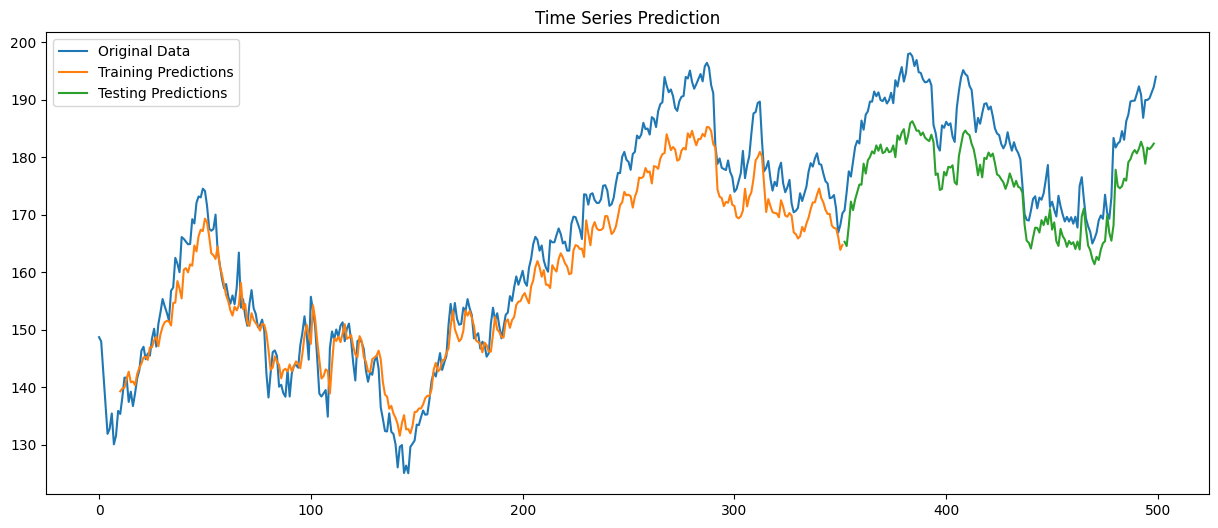

In [28]:
print(f"{time_step=}, {X.shape=}, {(len(train_predict) + time_step)=}")
print(f"{test_predict.shape=}, {train_predict.shape=}, {scaled_data.shape=}")

# Plot the predictions
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(scaled_data)[:, target_column_index], label='Original Data')
train_predict_plot = np.empty_like(scaled_data[:, target_column_index]).reshape(-1, 1)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
plt.plot(train_predict_plot, label='Training Predictions')

test_predict_plot = np.empty_like(scaled_data[:, target_column_index]).reshape(-1, 1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + time_step:len(scaled_data[:, target_column_index]) - 1, :] = test_predict
plt.plot(test_predict_plot, label='Testing Predictions')

plt.title('Time Series Prediction')
plt.legend()
plt.show()

In [ ]:
model.save('lstm_model_test.h5')

In [ ]:
# # Load the saved model
# loaded_model = load_model('lstm_model.h5')

In [ ]:
# # Assuming `X_new` and `Y_new` are new data arrays
# history_updated = loaded_model.fit(X_new, Y_new, epochs=50, batch_size=1, verbose=1)

# # Save the updated model
# loaded_model.save('updated_lstm_model.h5')